# Analysis of CBRAIN-CAM online runs

Goal: Get a standard set of analysis for online runs and compare to reference runs

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

In [182]:
DATA_DIR = '/beegfs/DATA/pritchard/srasp/'
%ls {DATA_DIR}

E002_fullphy_fbp32/          nnfullphy_fbp8_E001_andkua/  sp32fbp_andkua/
nnatmonly_fbp8_D001_3kw1/    nnfullphy_std8_A003/         sp8fbp_3kw1/
nnatmonly_fbp8_D002_3kw1/    nonsp_andkua@                sp8fbp_andkua/
nnatmonly_fbp8_D002_andkua/  old_data/                    tmp/
nnfullphy_fbp8_E001_3kw1/    preprocessed_data/


In [239]:
exps_andkua= ['sp8fbp_andkua', 'nnfullphy_fbp8_E001_andkua', 'nnatmonly_fbp8_D002_andkua', 
              'nnatmonly_fbp8_D003_andkua', 'nonsp_andkua']

In [359]:
exps_3kw1 = ['sp8fbp_3kw1', 'nnfullphy_fbp8_E001_3kw1', 'nnatmonly_fbp8_D002_3kw1', 'nonsp_3kw1']

In [298]:
exps_32 = ['sp32fbp_andkua', 'nnfullphy_fbp32_E002_andkua']

In [360]:
exps = exps_andkua + exps_3kw1 + exps_32

In [361]:
%%time
h0s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.0000-*', decode_times=False) for e in exps}

CPU times: user 29.8 s, sys: 2 ms, total: 29.8 s
Wall time: 35.6 s


In [338]:
def gw_avg(ds, var):
    return (ds[var] * ds['gw'].values.reshape(-1, 64, 1)).sum(dim=('lat', 'lon')) / 2

In [362]:
for d in h0s.values(): 
    d['vTAP'] = vint(d, 'TAP', C_P); d['vQAP'] = vint(d, 'QAP', L_V)
    d['vTPHY'] = vint(d, 'TPHYSTND', C_P); d['vPHQ'] = vint(d, 'PHQ', L_V)

In [363]:
def compare(func, exps, ref=None, title=None, **kwargs):
    npanels = len(exps) if ref is None else len(exps) + 1
    ncols=min(3, npanels); nrows=int(np.ceil(npanels/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4*nrows));
    if ref is None:
        [func(h0s[e]).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat)]
        [ax.set_title(e) for e, ax in zip(exps, axs.flat)]
    else:
        yi = kwargs['yincrease'] if 'yincrease' in kwargs.keys() else None
        func(h0s[ref]).plot(ax=axs.flat[0], yincrease=yi); axs.flat[0].set_title(ref)
        [(func(h0s[e])-func(h0s[ref]).values).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat[1:])]
        [ax.set_title(f'{e} - {ref}') for e, ax in zip(exps, axs.flat[1:])]
    if title is None: plt.tight_layout()
    else: fig.suptitle(title); plt.tight_layout(rect=(0, 0, 1, 0.95))
    return fig, axs

In [93]:
def compare_line(func, exps, ax=None, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 5))
    [func(h0s[e]).plot(ax=ax, label=e, **kwargs) for e in exps]
    ax.legend()

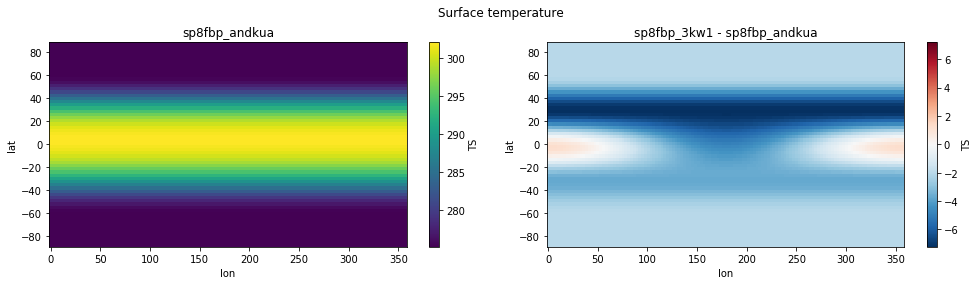

In [202]:
compare(lambda d: d['TS'].isel(time=0), [exps_3kw1[0]], ref = exps_andkua[0], title='Surface temperature')

## Global energetics

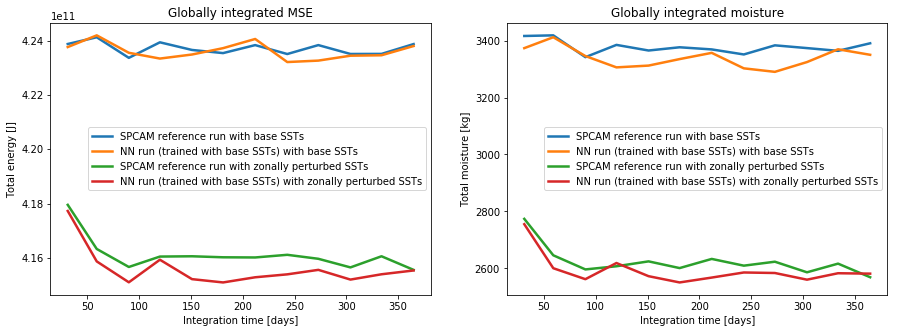

In [350]:
# Figure for Mike
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua',
                                         'sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1'], ax=axs[0], lw=2.5)
compare_line(lambda d: gw_avg(d, 'TW'), ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua',
                                         'sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1'], ax=axs[1], lw=2.5)
axs[0].set_title('Globally integrated MSE'); axs[1].set_title('Globally integrated moisture')
axs[0].set_ylabel('Total energy [J]'); axs[1].set_ylabel('Total moisture [kg]')
[ax.set_xlabel('Integration time [days]') for ax in axs];
[ax.legend(['SPCAM reference run with base SSTs', 'NN run (trained with base SSTs) with base SSTs',
            'SPCAM reference run with zonally perturbed SSTs', 'NN run (trained with base SSTs) with zonally perturbed SSTs']) 
 for ax in axs];

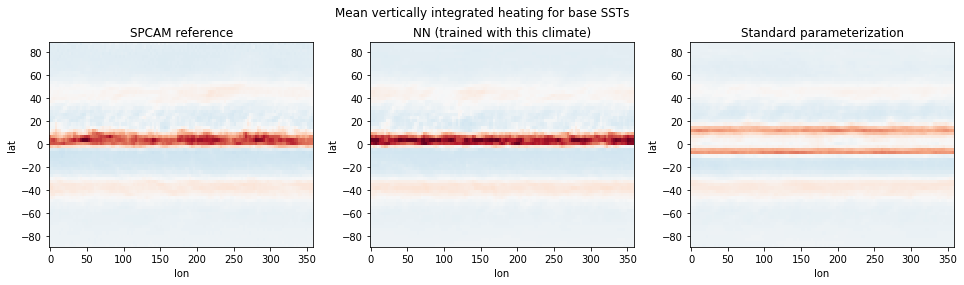

In [372]:
fig, axs = compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), 
        ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua', 'nonsp_andkua'],
        title='Mean vertically integrated heating for base SSTs', vmin=-500, vmax=500, cmap='RdBu_r', 
                   add_colorbar=False)
[ax.set_title(t) for ax, t in 
 zip(axs.flat, ['SPCAM reference', 'NN (trained with this climate)', 'Standard parameterization'])];

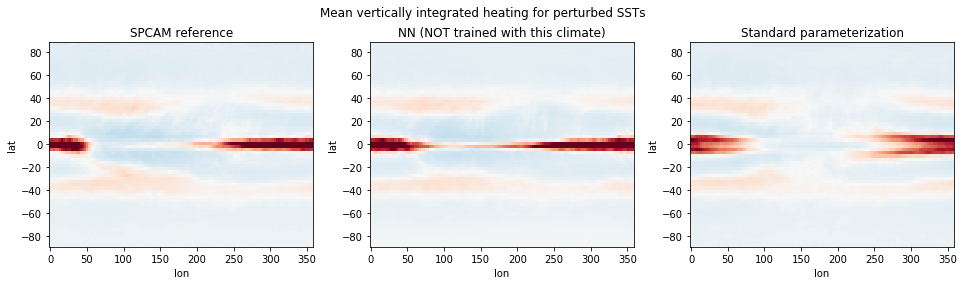

In [373]:
fig, axs = compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), 
        ['sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1', 'nonsp_3kw1'],
        title='Mean vertically integrated heating for perturbed SSTs', vmin=-500, vmax=500, cmap='RdBu_r', 
                   add_colorbar=False)
[ax.set_title(t) for ax, t in 
 zip(axs.flat, ['SPCAM reference', 'NN (NOT trained with this climate)', 'Standard parameterization'])];

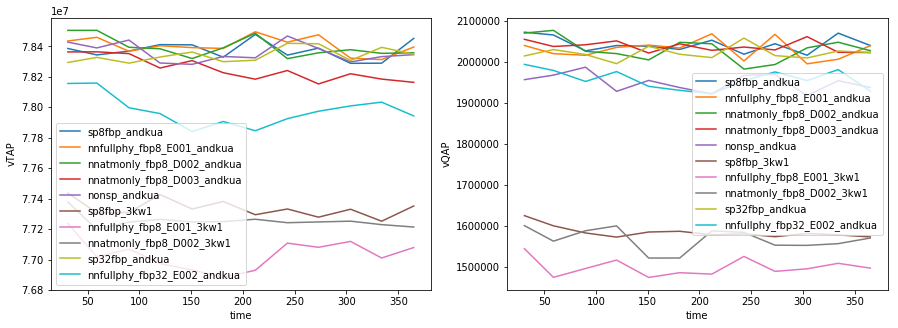

In [308]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'vTAP'), exps, ax=axs[0])
compare_line(lambda d: gw_avg(d, 'vQAP'), exps, ax=axs[1])

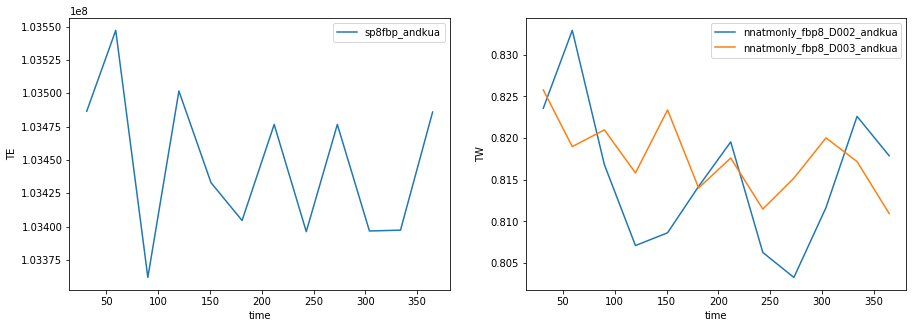

In [325]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), [exps_andkua[0]], ax=axs[0])
compare_line(lambda d: gw_avg(d, 'TW'), exps_andkua[2:4], ax=axs[1])

## Reference SST runs

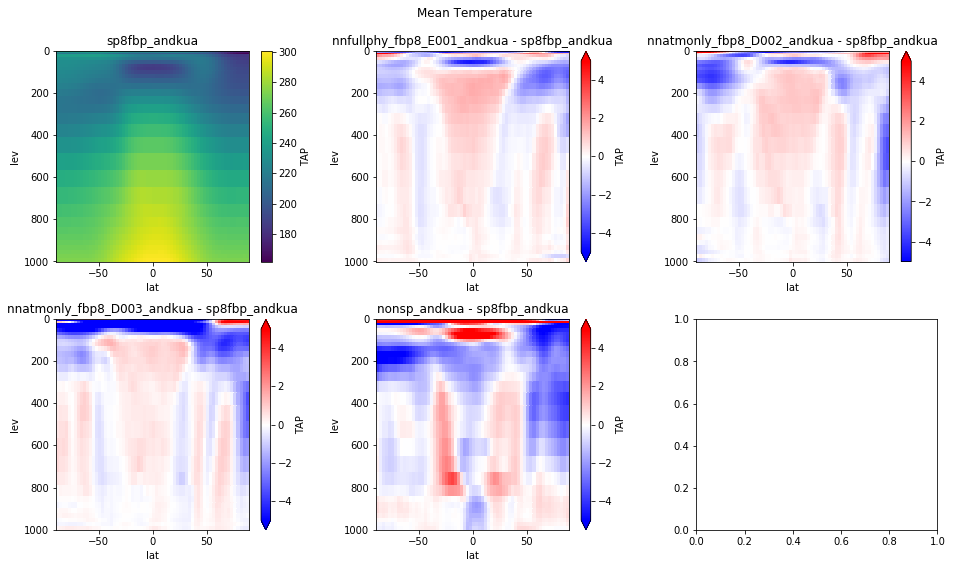

In [254]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature')

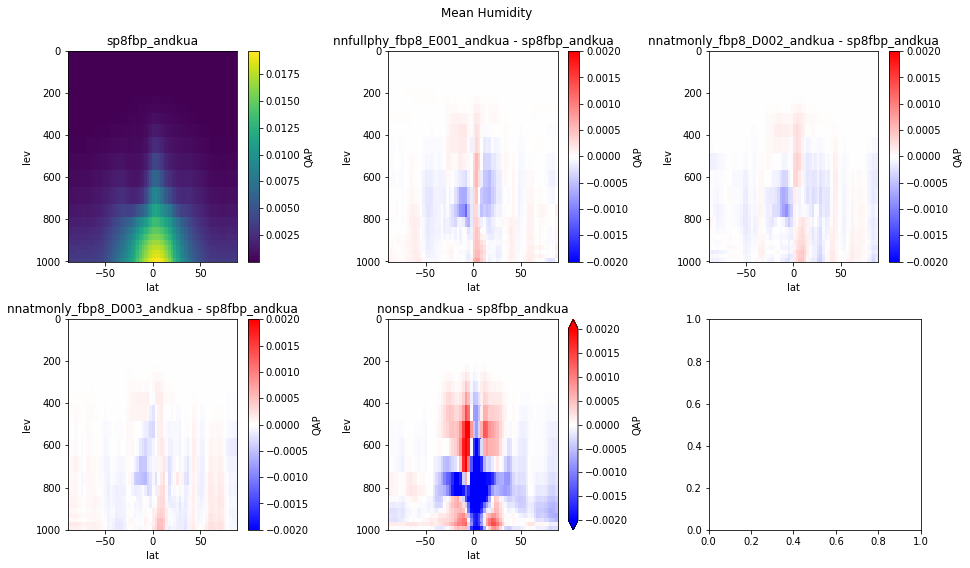

In [255]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity')

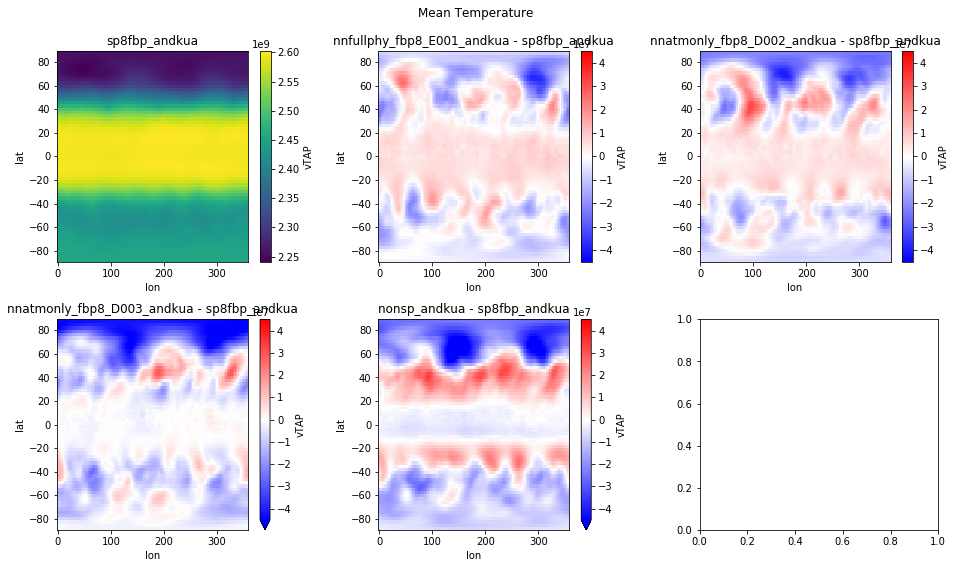

In [263]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7)

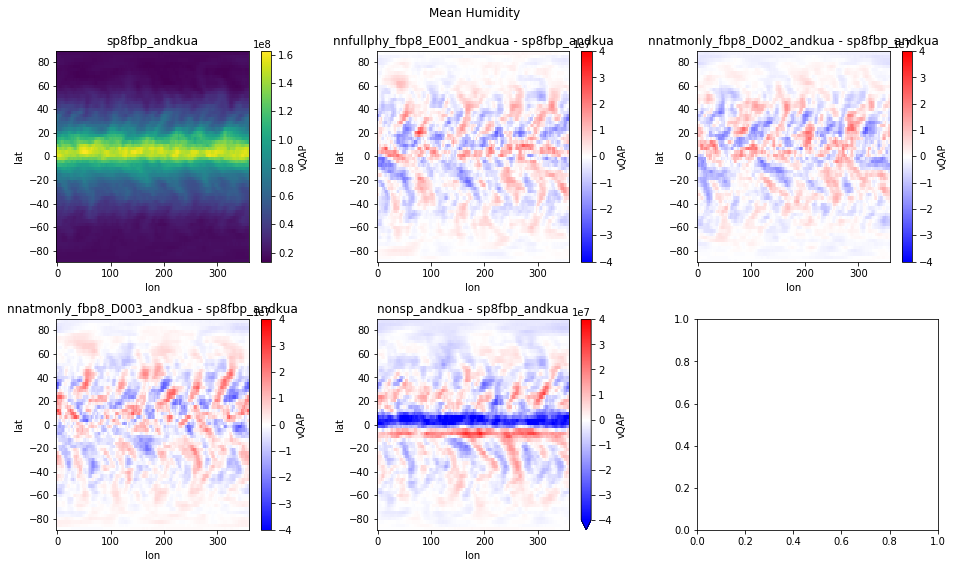

In [265]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7)

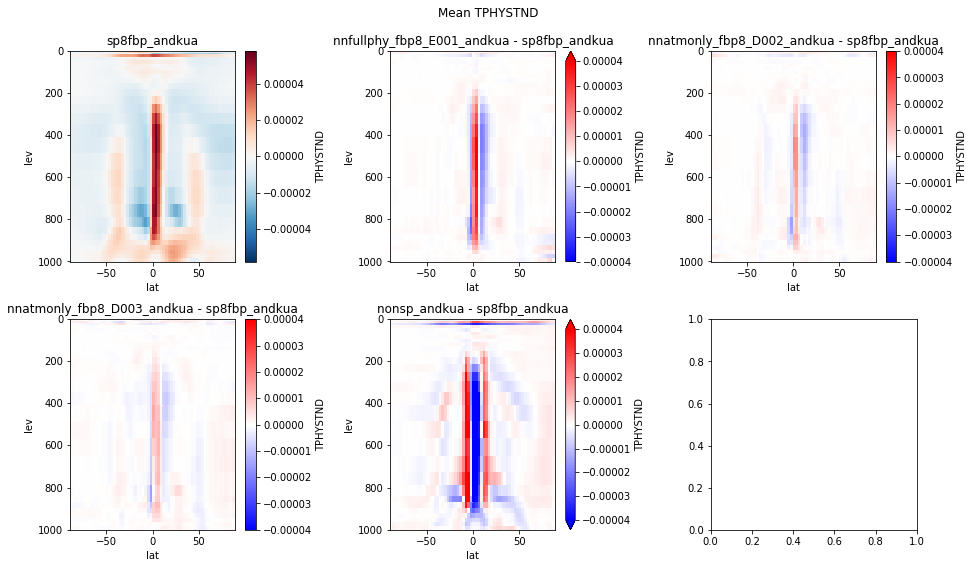

In [268]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5)

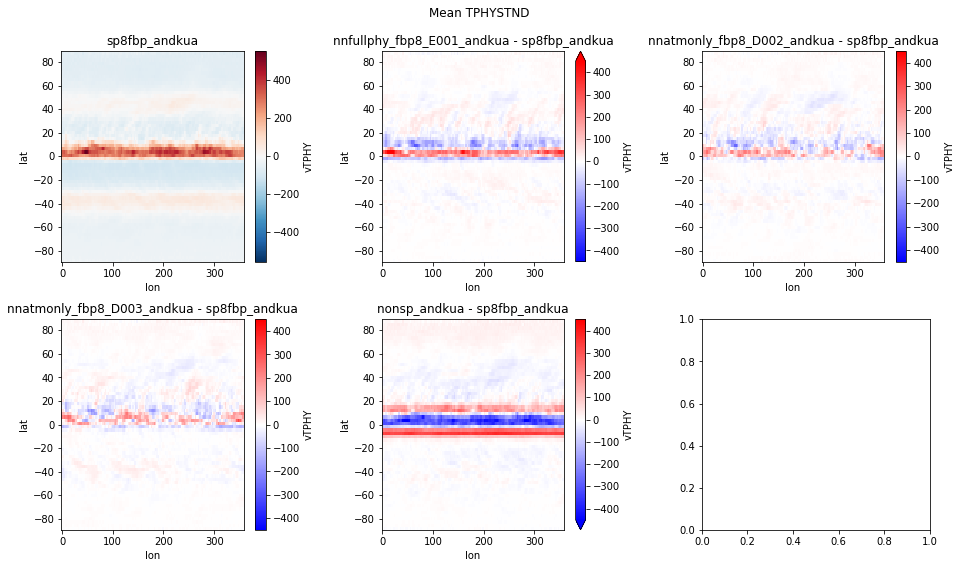

In [272]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450)

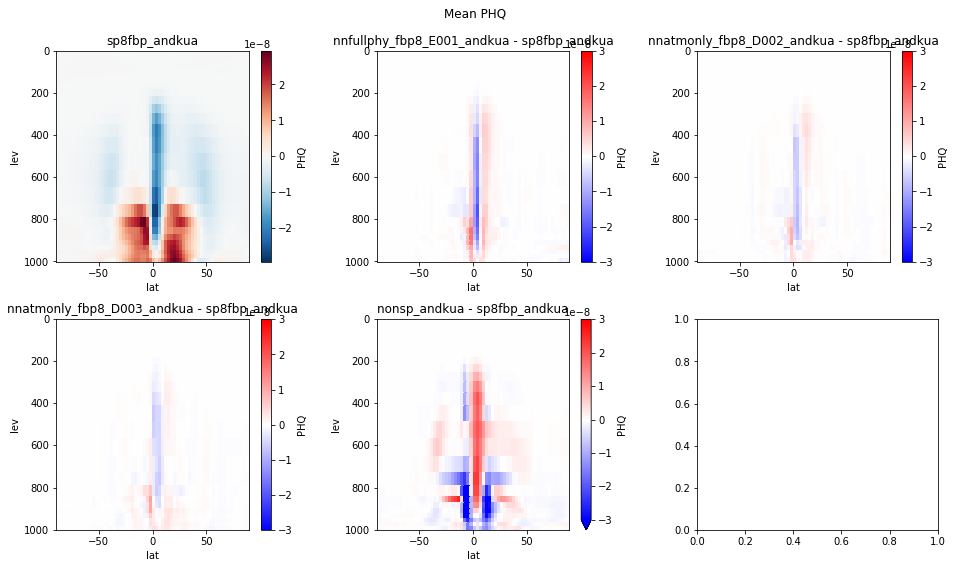

In [276]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8)

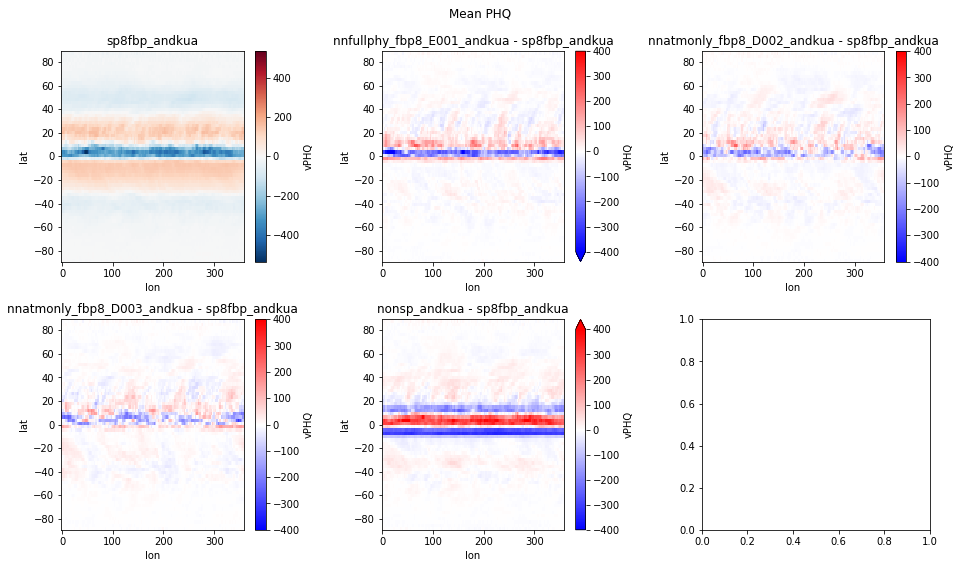

In [277]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400)

## 3KW1 Runs

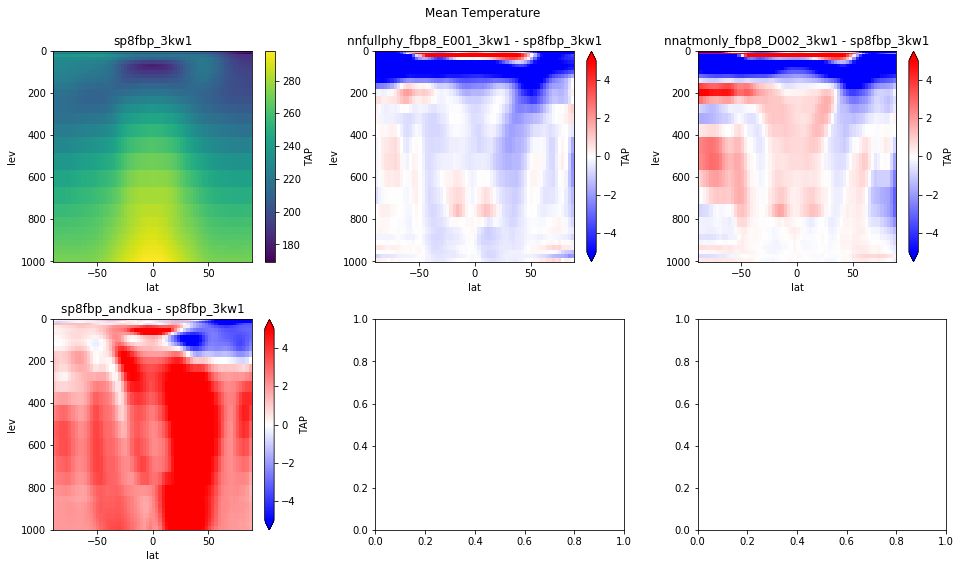

In [318]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature')

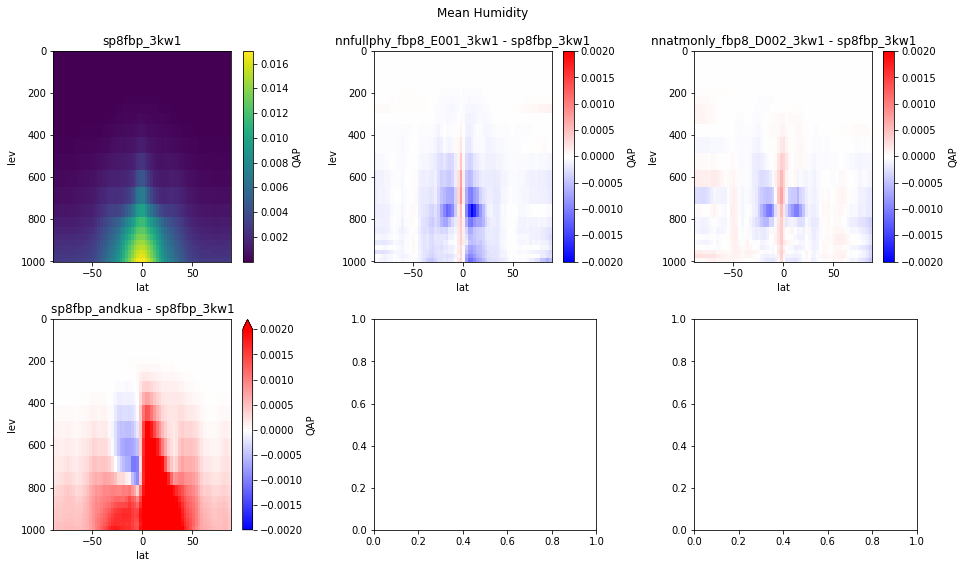

In [319]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity')

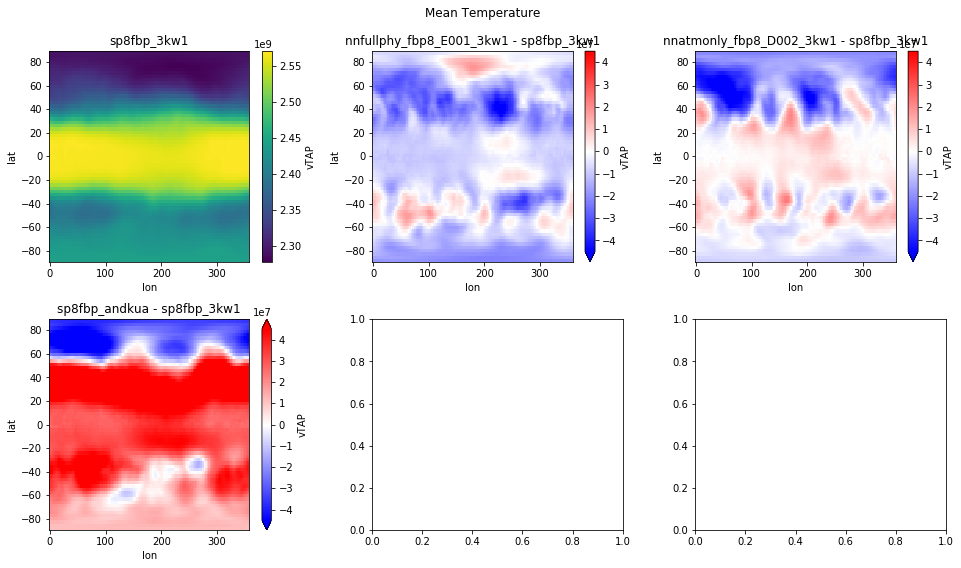

In [320]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7)

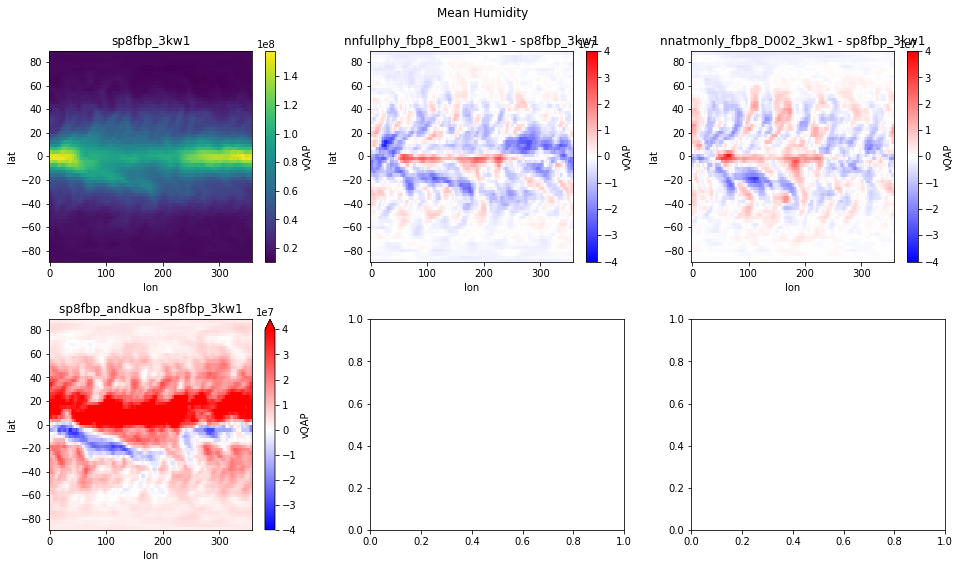

In [321]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7)

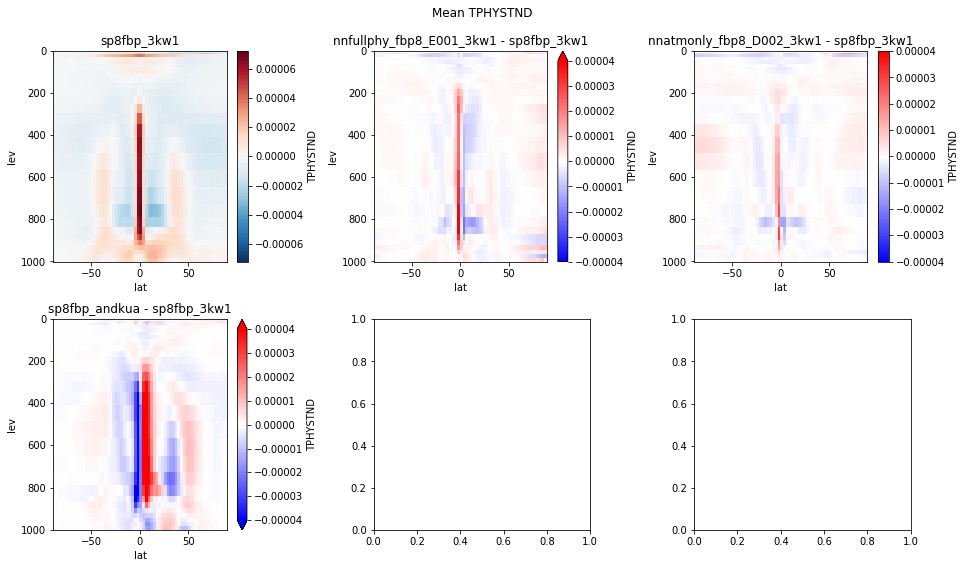

In [322]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5)

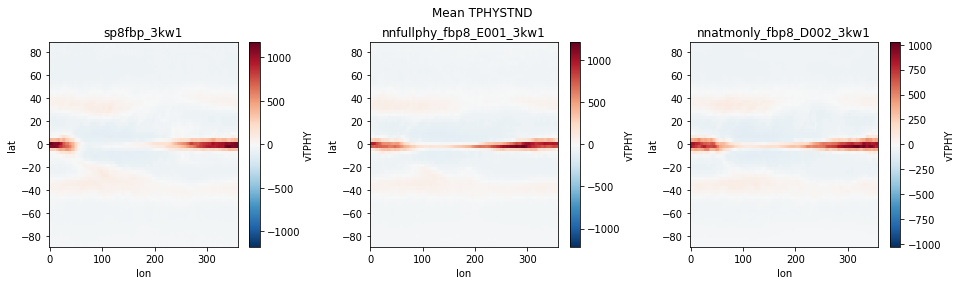

In [293]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1,
        title='Mean TPHYSTND')

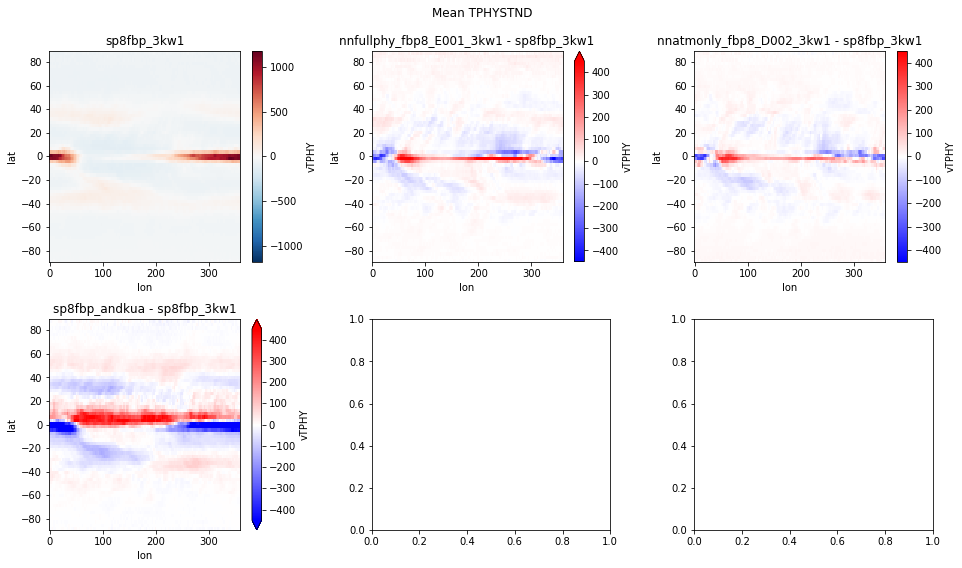

In [323]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450)

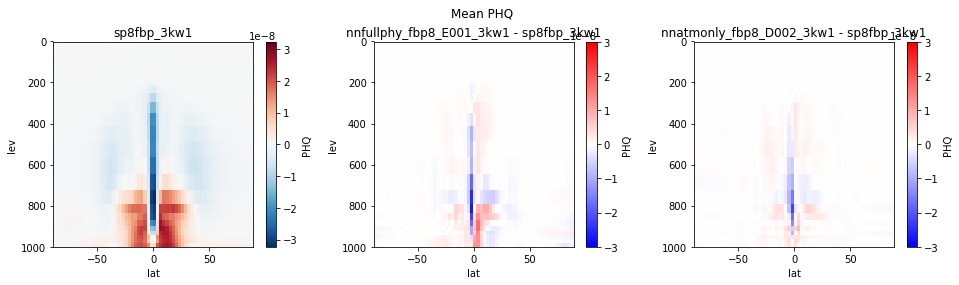

In [291]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8)

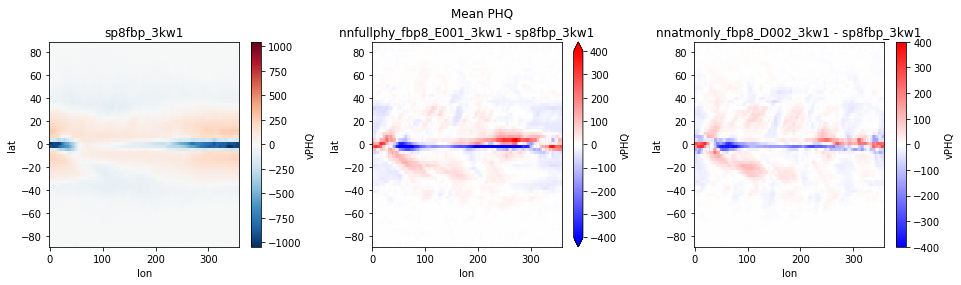

In [292]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:], ref=exps_3kw1[0],
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400)

## 8 vs 32 cols

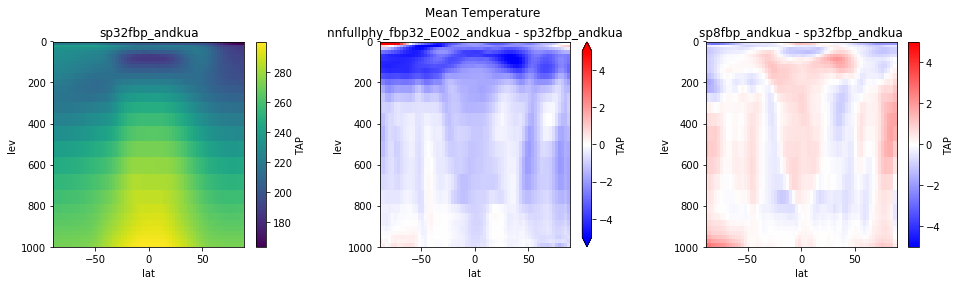

In [309]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature')

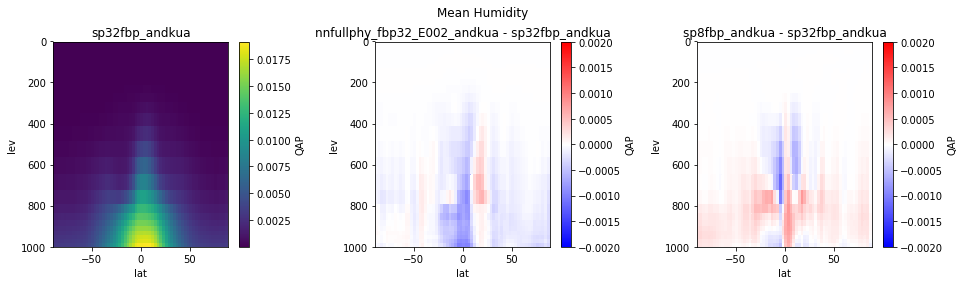

In [310]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity')

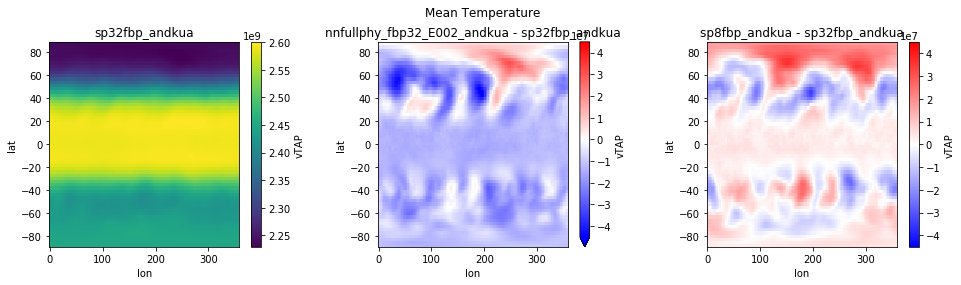

In [311]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7)

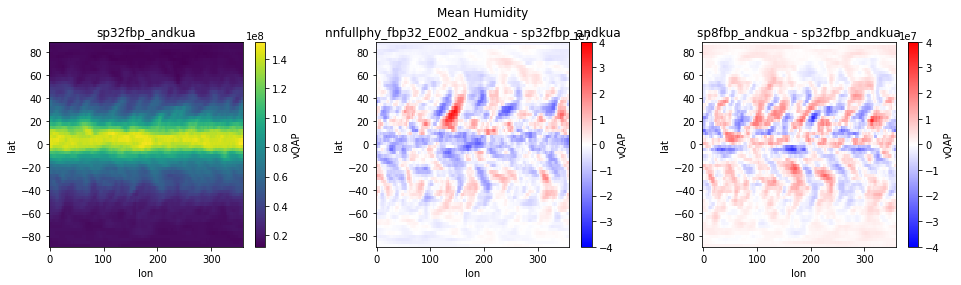

In [312]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7)

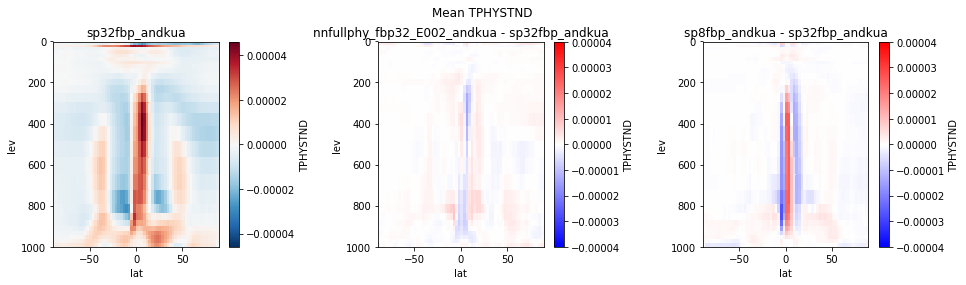

In [313]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5)

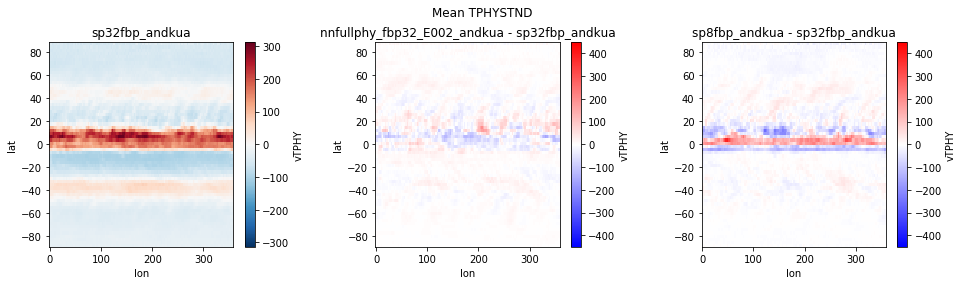

In [314]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450)

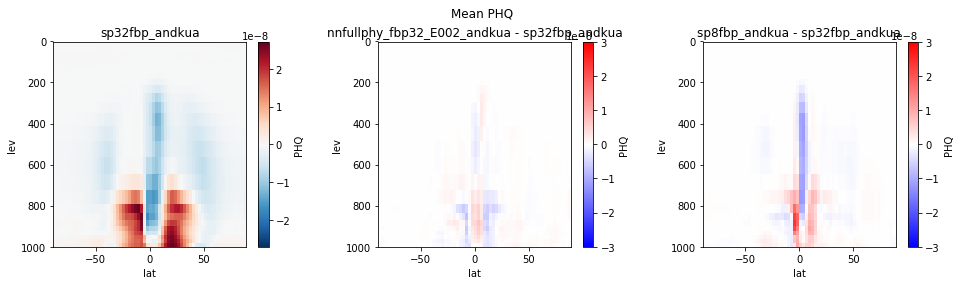

In [315]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8)

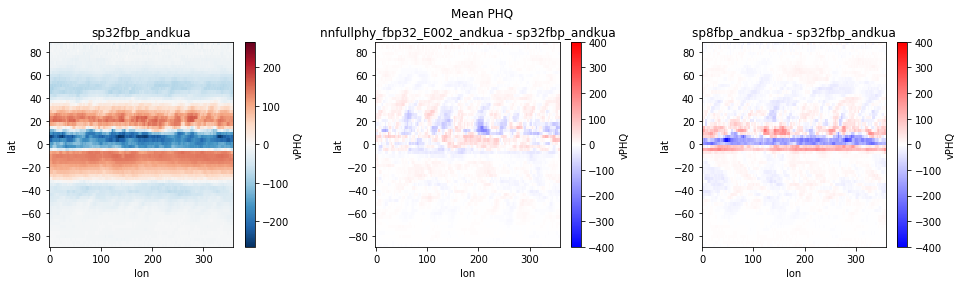

In [316]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400)

## More to come

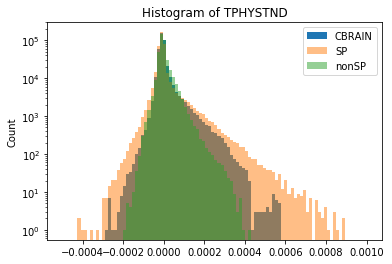

In [42]:
dcbrain['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

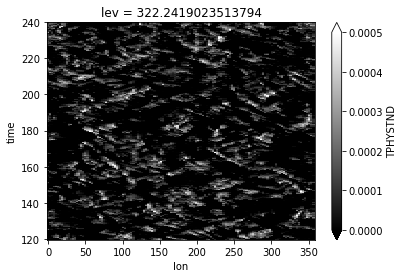

In [130]:
dsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

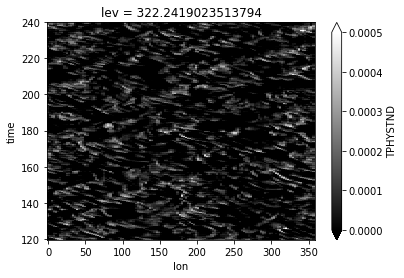

In [131]:
dcbrain['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

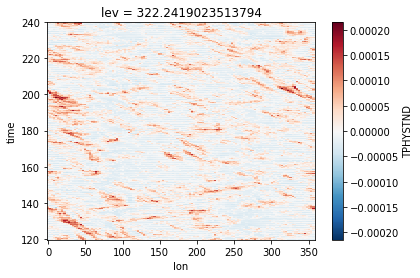

In [127]:
dnonsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(0, 10)).mean('lat').plot()

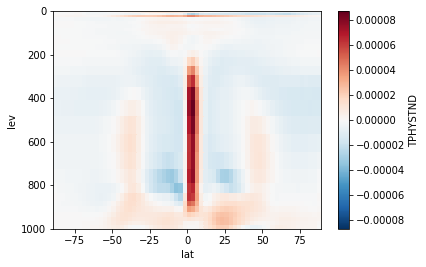

In [121]:
TPHYSTNDmeans[0].mean('lon').plot(yincrease=False)

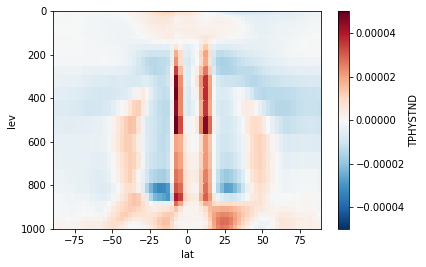

In [128]:
TPHYSTNDmeans[2].mean('lon').plot(yincrease=False)

In [94]:
tmp = xr.open_dataset('/scratch/05488/tg847872/sp8fbp_andkua/sp8fbp_andkua.cam2.h1.0000-01-01-00000.nc',
                     decode_times=False)

In [96]:
tmp.time

<xarray.DataArray 'time' (time: 13)>
array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125,
       1.25 , 1.375, 1.5  ])
Coordinates:
  * time     (time) float64 0.0 0.125 0.25 0.375 0.5 0.625 0.75 0.875 1.0 ...
Attributes:
    long_name:  time
    units:      days since 0000-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bnds

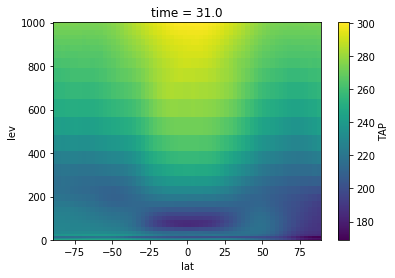

In [91]:
tmp.TAP.mean('lon').plot()